In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import numpy as np
from IPython.display import display
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pythainlp.word_vector import sentence_vectorizer

/Users/eqsk134/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv('../../data/the_standard_data_with_features.csv')

In [3]:
data = pd.concat([pd.read_csv('../../data/Ch3_with_features.csv'),
                  pd.read_csv('../../data/ch3_with_features_2.csv')])

In [4]:
len(data)

45269

## Prepare Data

/Users/eqsk134/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


44258


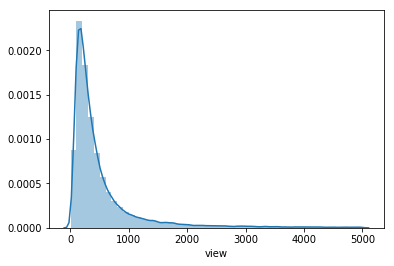

In [5]:
out = data[data['view']<5000]['view']
sns.distplot(out)
print(len(out))

In [6]:
boundary = 10000000
data_bounded = data[data['view']<boundary]
x = data_bounded['view']
std = np.std(x)
mean = np.mean(x)
groups = [0,161,268,384,525,1369,4778,24006,196995,boundary]
print('STD : ',std)
print('MEAN : ',mean)
print(groups)

STD :  3441.6844046949786
MEAN :  825.0044622147607
[0, 161, 268, 384, 525, 1369, 4778, 24006, 196995, 10000000]


In [7]:
pop_level = []
for i in data['view']:
    for j in range(len(groups)-1):
        if i >= groups[j] and i <= groups[j+1]:
            pop_level+=[j]
            continue

In [8]:
print(np.unique(pop_level,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 9754, 10105,  7217,  5366,  8670,  3351,   961,   117,     2]))


<b>Numerical Features</b>

In [9]:
numerical_feature = [
       'numTag', 'numToken', 'numChar','timeDelta', 'num_noun', 'num_pronoun', 'num_verb',
       'num_preverb', 'num_determiner', 'num_adverb', 'num_classifier',
       'num_conjunction', 'num_preposition', 'num_interjunction', 'num_prefix',
       'num_ending', 'num_negator', 'num_punctuation',
       'nnoun_per_ntoken', 'nverb_per_ntoken', 'nadverb_per_ntoken',
       'num_date', 'num_email', 'num_law', 'num_len', 'num_location',
       'num_money', 'num_organization', 'num_percent', 'num_person',
       'num_phone', 'num_time', 'num_url', 'num_person_2', 'num_pos',
       'num_neg', 'sim_top', 'sim_worst', 'tag_pop_sum',
       'tag_pop_mean', 'tag_top_pop_sum', 'tag_top_pop_mean', 'num_tag_pop',
       'tag_top_worst_sum', 'tag_top_worst_mean', 'num_tag_worst']

In [10]:
numerical_feature_data = data[numerical_feature]

In [11]:
numerical_feature_data = numerical_feature_data.values

In [12]:
numerical_feature_data.shape

(45269, 46)

<b>Categorical Features</b>

In [13]:
categorical_feature = [i for i in data.columns if 'is_' in i]

In [14]:
categorical_feature_data = data[categorical_feature].values

In [15]:
categorical_feature_data.shape

(45269, 11)

<b>Title Tokenized Features</b>

In [16]:
title_tokenized = data['token'].apply(lambda x : x.split(','))

In [17]:
word_count = dict()
for headline in title_tokenized:
    for word in headline:
        if word not in word_count:
            word_count[word]=1
        else:
            word_count[word]+=1

In [18]:
word_to_idx = dict()
idx = 2
for key,val in word_count.items():
    if(val > 10):
        word_to_idx[key] = idx
        idx+=1
    else:
        word_to_idx['UNK'] = 1


In [19]:
idx_to_word = {v: k for k, v in word_to_idx.items()}

In [20]:
title_tokenized_features_data = title_tokenized.apply(lambda x : [word_to_idx[i] if i in word_to_idx else word_to_idx['UNK'] for i in x ])
title_tokenized_features_data = title_tokenized_features_data.values

In [21]:
title_tokenized_features_data = pad_sequences(title_tokenized_features_data)

In [22]:
title_tokenized_features_data.shape

(45269, 26)

<b>Pre-Trained Embedded</b>

In [23]:
from pythainlp.word_vector import sentence_vectorizer
pre_trained_weights = []
# pre_trained_weights += [[0] * 300]
for i in range(1,len(idx_to_word)):
    weight = sentence_vectorizer(idx_to_word[i])
    pre_trained_weights+=[weight]

In [24]:
pre_trained_weights = np.asarray(pre_trained_weights)

In [25]:
pre_trained_weights.shape

(3636, 1, 300)

In [26]:
# pre_trained_weights = np.concatenate((np.zeros((1, 1, 300)),pre_trained_weights), axis=0)

In [27]:
pre_trained_weights.shape

(3636, 1, 300)

In [28]:
pre_trained_weights = pre_trained_weights.reshape((3636,300))

<b>NER</b>

In [26]:
!pip install sklearn-crfsuite

In [29]:
from pythainlp.tag.named_entity import ThaiNameTagger
from pythainlp.tag import pos_tag

In [30]:
ner_tagger = ThaiNameTagger()

In [31]:
headlines = data['token']
headlines = headlines.apply(lambda x : x.split(','))
headlines = [[ner_tagger.get_ner(i)[0] for i in tokens] for tokens in headlines]

In [32]:
ner = set()
pos = set()
for hl in headlines:
    for word in hl:
        ner.add(word[1])
        pos.add(word[2])

In [33]:
ner = list(ner)
pos = list(pos)
ner_idx = [i for i in range(1,len(ner)+1)]
pos_idx = [i for i in range(1,len(pos)+1)]

In [34]:
ner_to_idx = dict(zip(ner,ner_idx))
idx_to_ner = {v: k for k, v in ner_to_idx.items()}

pos_to_idx = dict(zip(pos,pos_idx))
idx_to_pos = {v: k for k, v in pos_to_idx.items()}

In [35]:
data_ner = headlines
x = []
for idx in range(len(data_ner)):
    temp = []
    for word in data_ner[idx]:
        temp+=[ner_to_idx[word[1]]]
        temp+=[pos_to_idx[word[2]]]
    x+=[temp]
x = np.asarray(x)

In [36]:
ner_features = pad_sequences(x)

In [37]:
ner_features.shape

(45269, 52)

Prepare Y

In [38]:
def prepare_y(data):
    y = []
    for i in data:
        c = 0
        for j in range(len(groups)-1):
            if i >= groups[j] and i <= groups[j+1]:
                y+=[j]
                c=1
                break
        if c==0:
            y+=[0]
        
    return y

In [39]:
y_train = prepare_y(np.asarray(data['view']))
y_train = to_categorical(y_train)

In [40]:
y_train.shape

(45269, 9)

## Model

In [45]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, BatchNormalization, GRU, Conv1D, Dropout, Embedding, concatenate, Flatten
from keras.optimizers import Adam

In [46]:
def get_categorical_model_part(category_count,input_shape):
    input1 = Input(shape=(input_shape,))
#     x = Embedding(category_count,32)(input1)
    x = input1
#     x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    return input1, x    

In [47]:
def get_numerical_model_part(features_len,input_shape):
    input1 = Input(shape=(input_shape,))
    x = Dense(256,activation='relu')(input1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    return input1, x

In [48]:
def get_title_embedding_part(word_count,input_shape):
    input1 = Input(shape=(input_shape,))
    x = input1
#     x = Embedding(word_count-1,300,trainable=True,weights=[pre_trained_weights])(input1)
#     x = Flatten()(x)
    
    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    return input1, x

In [49]:
def get_keyword_embedding_part(keyword_count,input_shape):
    input1 = Input(shape=(input_shape,))
    x = input1
    x = Embedding(keyword_count,32)(input1)
    x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return input1, x

In [50]:
def get_ner_part(input_shape):
    input1 = Input(shape=(input_shape,))
    x = Dense(256,activation='relu')(input1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    return input1, x

In [51]:
def get_model():
    input1, m1 = get_categorical_model_part(categorical_feature_data.shape[1],categorical_feature_data.shape[1])
    input2, m2 = get_numerical_model_part(numerical_feature_data.shape[1],numerical_feature_data.shape[1])
    input3, m3 = get_title_embedding_part(len(word_to_idx),title_tokenized_features_data.shape[1])
    input4, m4 = get_ner_part(ner_features.shape[1])
    x = concatenate([m1,m2,m3,m4])
#     x = concatenate([m2,m3,m4])
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(y_train.shape[1],activation='softmax')(x)
    model = Model(inputs=[input1,input2,input3,input4], outputs=x)
#     model = Model(inputs=[input2,input3,input4], outputs=x)
    adam  = Adam(lr=3e-5)
    model.compile(optimizer=adam,  loss='categorical_crossentropy' ,metrics=['accuracy'])
    
    return model
    

In [52]:
model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 46)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 52)           0                                            
__________________________________________________________________________________________________
dense_1 (D

In [109]:
pre_trained_weights.shape

(3636, 300)

In [41]:
# train_data = [numerical_feature_data,title_tokenized_features_data,ner_features]
train_data = [categorical_feature_data,numerical_feature_data,title_tokenized_features_data,ner_features]
train_x = []
temp_train_x = []
test_x = []
val_x = []
for data in train_data:
    train, test = train_test_split(data, test_size=0.1,random_state=22)
    temp_train_x += [train]
    test_x += [test]
for data in temp_train_x:
    train, val = train_test_split(data, test_size=0.1,random_state=22)
    train_x += [train]
    val_x += [val]
temp_train_y, test_y = train_test_split(y_train, test_size=0.1,random_state=22)
train_y, val_y = train_test_split(temp_train_y, test_size=0.1,random_state=22)


In [54]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
init_op = tf.global_variables_initializer()

sess = tf.Session(config=config)
sess.run(init_op)
set_session(sess)

In [55]:
import keras
filepath="model13.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
model.fit(train_x, train_y, batch_size=64, callbacks=callbacks_list ,epochs=250, verbose=1, validation_data=[val_x, val_y])

Instructions for updating:
Use tf.cast instead.
Train on 36667 samples, validate on 4075 samples
Epoch 1/250
36667/36667 [==============================] - 23s 623us/step - loss: 3.1298 - acc: 0.1178 - val_loss: 2.4091 - val_acc: 0.0805
Epoch 2/250
36667/36667 [==============================] - 16s 433us/step - loss: 2.9644 - acc: 0.1304 - val_loss: 2.2599 - val_acc: 0.1377
Epoch 3/250
36667/36667 [==============================] - 17s 453us/step - loss: 2.8230 - acc: 0.1394 - val_loss: 2.1752 - val_acc: 0.1799
Epoch 4/250
36667/36667 [==============================] - 16s 443us/step - loss: 2.7137 - acc: 0.1495 - val_loss: 2.1061 - val_acc: 0.2137
Epoch 5/250
36667/36667 [==============================] - 17s 465us/step - loss: 2.6039 - acc: 0.1630 - val_loss: 2.0446 - val_acc: 0.2307
Epoch 6/250
36667/36667 [==============================] - 17s 475us/step - loss: 2.5231 - acc: 0.1716 - val_loss: 2.0103 - val_acc: 0.2547
Epoch 7/250
36667/36667 [==============================] - 17s 

Epoch 57/250
36667/36667 [==============================] - 21s 559us/step - loss: 1.6829 - acc: 0.3129 - val_loss: 1.6308 - val_acc: 0.3399
Epoch 58/250
36667/36667 [==============================] - 13s 361us/step - loss: 1.6793 - acc: 0.3102 - val_loss: 1.6290 - val_acc: 0.3426
Epoch 59/250
36667/36667 [==============================] - 13s 342us/step - loss: 1.6815 - acc: 0.3124 - val_loss: 1.6262 - val_acc: 0.3416
Epoch 60/250
36667/36667 [==============================] - 13s 341us/step - loss: 1.6752 - acc: 0.3143 - val_loss: 1.6227 - val_acc: 0.3431
Epoch 61/250
36667/36667 [==============================] - 16s 448us/step - loss: 1.6681 - acc: 0.3144 - val_loss: 1.6214 - val_acc: 0.3465
Epoch 62/250
36667/36667 [==============================] - 21s 574us/step - loss: 1.6675 - acc: 0.3174 - val_loss: 1.6186 - val_acc: 0.3436
Epoch 63/250
36667/36667 [==============================] - 21s 581us/step - loss: 1.6649 - acc: 0.3170 - val_loss: 1.6137 - val_acc: 0.3440
Epoch 64/250


Epoch 115/250
36667/36667 [==============================] - 20s 543us/step - loss: 1.5968 - acc: 0.3401 - val_loss: 1.5557 - val_acc: 0.3600
Epoch 116/250
36667/36667 [==============================] - 20s 553us/step - loss: 1.5961 - acc: 0.3411 - val_loss: 1.5555 - val_acc: 0.3553
Epoch 117/250
36667/36667 [==============================] - 18s 478us/step - loss: 1.5935 - acc: 0.3409 - val_loss: 1.5529 - val_acc: 0.3585
Epoch 118/250
36667/36667 [==============================] - 19s 512us/step - loss: 1.5958 - acc: 0.3412 - val_loss: 1.5568 - val_acc: 0.3573
Epoch 119/250
36667/36667 [==============================] - 25s 669us/step - loss: 1.5905 - acc: 0.3399 - val_loss: 1.5529 - val_acc: 0.3610
Epoch 120/250
36667/36667 [==============================] - 22s 609us/step - loss: 1.5932 - acc: 0.3385 - val_loss: 1.5518 - val_acc: 0.3590
Epoch 121/250
36667/36667 [==============================] - 24s 661us/step - loss: 1.5915 - acc: 0.3388 - val_loss: 1.5514 - val_acc: 0.3585
Epoch 

36667/36667 [==============================] - 29s 792us/step - loss: 1.5582 - acc: 0.3550 - val_loss: 1.5202 - val_acc: 0.3676
Epoch 173/250
36667/36667 [==============================] - 25s 671us/step - loss: 1.5550 - acc: 0.3555 - val_loss: 1.5213 - val_acc: 0.3698
Epoch 174/250
36667/36667 [==============================] - 24s 667us/step - loss: 1.5564 - acc: 0.3575 - val_loss: 1.5183 - val_acc: 0.3701
Epoch 175/250
36667/36667 [==============================] - 18s 495us/step - loss: 1.5552 - acc: 0.3585 - val_loss: 1.5183 - val_acc: 0.3686
Epoch 176/250
36667/36667 [==============================] - 21s 582us/step - loss: 1.5543 - acc: 0.3569 - val_loss: 1.5160 - val_acc: 0.3735
Epoch 177/250
36667/36667 [==============================] - 22s 596us/step - loss: 1.5520 - acc: 0.3574 - val_loss: 1.5189 - val_acc: 0.3706
Epoch 178/250
36667/36667 [==============================] - 18s 483us/step - loss: 1.5600 - acc: 0.3557 - val_loss: 1.5189 - val_acc: 0.3688
Epoch 179/250
36667/

36667/36667 [==============================] - 27s 750us/step - loss: 1.5250 - acc: 0.3689 - val_loss: 1.5053 - val_acc: 0.3750
Epoch 230/250
36667/36667 [==============================] - 27s 742us/step - loss: 1.5293 - acc: 0.3655 - val_loss: 1.5004 - val_acc: 0.3818
Epoch 231/250
36667/36667 [==============================] - 28s 752us/step - loss: 1.5312 - acc: 0.3655 - val_loss: 1.5020 - val_acc: 0.3777
Epoch 232/250
36667/36667 [==============================] - 27s 749us/step - loss: 1.5259 - acc: 0.3671 - val_loss: 1.5004 - val_acc: 0.3777
Epoch 233/250
36667/36667 [==============================] - 28s 755us/step - loss: 1.5247 - acc: 0.3690 - val_loss: 1.5010 - val_acc: 0.3784
Epoch 234/250
36667/36667 [==============================] - 27s 746us/step - loss: 1.5258 - acc: 0.3663 - val_loss: 1.4990 - val_acc: 0.3804
Epoch 235/250
36667/36667 [==============================] - 27s 732us/step - loss: 1.5253 - acc: 0.3716 - val_loss: 1.4998 - val_acc: 0.3777
Epoch 236/250
36667/

In [56]:
import keras
filepath="model14.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
model.fit(train_x, train_y, batch_size=64, callbacks=callbacks_list ,epochs=50, verbose=1, validation_data=[val_x, val_y])

Train on 36667 samples, validate on 4075 samples
Epoch 1/50
36667/36667 [==============================] - 26s 699us/step - loss: 1.5232 - acc: 0.3688 - val_loss: 1.5007 - val_acc: 0.3720
Epoch 2/50
36667/36667 [==============================] - 24s 664us/step - loss: 1.5231 - acc: 0.3681 - val_loss: 1.5026 - val_acc: 0.3718
Epoch 3/50
36667/36667 [==============================] - 24s 662us/step - loss: 1.5218 - acc: 0.3681 - val_loss: 1.4999 - val_acc: 0.3767
Epoch 4/50
36667/36667 [==============================] - 23s 632us/step - loss: 1.5188 - acc: 0.3712 - val_loss: 1.4968 - val_acc: 0.3740
Epoch 5/50
36667/36667 [==============================] - 23s 630us/step - loss: 1.5179 - acc: 0.3709 - val_loss: 1.4979 - val_acc: 0.3787
Epoch 6/50
36667/36667 [==============================] - 17s 450us/step - loss: 1.5180 - acc: 0.3731 - val_loss: 1.5026 - val_acc: 0.3742
Epoch 7/50
36667/36667 [==============================] - 18s 495us/step - loss: 1.5199 - acc: 0.3706 - val_loss: 1.5

In [57]:
from keras.models import load_model
model = load_model('model14.hdf5')


In [75]:
y_pred = model.predict(test_x)

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_y, y_pred))
rms

0.28467953692792647

In [64]:
mae = np.sum(np.absolute((test_y.astype("float") - y_pred.astype("float"))))/len(y_pred)
mae

1.4632410331495544

In [73]:
def evaluate(y_pred,y_test):
    correct = 0
    wrong = 0
    count = [0,0,0,0,0,0,0,0,0]
    heatmap =[[0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0]]
    true_pred = [0]*7
    for i in range(len(y_pred)):
        p_level_pred = np.argmax(y_pred[i])
        p_level_test = np.argmax(y_test[i])
        count[p_level_pred]+=1
        heatmap[p_level_test][p_level_pred]+=1
        if(p_level_pred == p_level_test):
            true_pred[p_level_pred] += 1
            correct += 1
        else:
            wrong +=1
    print(np.asarray(heatmap))
    heatmap = [[line[i]/np.sum(line) for i in range(len(line))] for line in heatmap]
    print(count)
    return correct/(correct+wrong), heatmap

In [76]:
score, heatmap = evaluate(y_pred,test_y)
print(score)
# print(heatmap)

[[518 282   2   0 112   5   0   0   0]
 [193 524  11   0 292   4   2   0   0]
 [106 280  24   0 313   3   0   0   0]
 [ 62 180  10   0 278   2   1   0   0]
 [106 238   7   0 545   9   2   0   0]
 [ 37  71   2   0 114  66  35   0   0]
 [  0   0   0   0   0  27  52   0   0]
 [  0   0   0   0   0   3   9   0   0]
 [  0   0   0   0   0   0   0   0   0]]
[1022, 1575, 56, 0, 1654, 119, 101, 0, 0]
0.38193063839187097


/Users/eqsk134/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


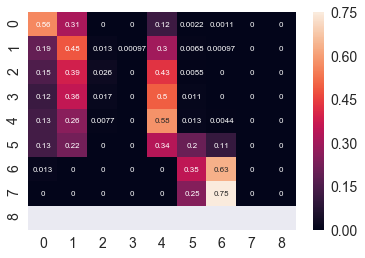

In [167]:
df_cm = pd.DataFrame(heatmap, range(9),
                  range(9))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 8})

In [252]:
def evaluate_f1(y_pred, y_test):
    acc = 0
    pred = list()
    true = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))
        true.append(np.argmax(y_test[i]))
    return f1_score(true, pred, average='micro'),pred,true

In [187]:
score, pred, true = evaluate_f1(y_pred,test_y)

In [188]:
print(score)

0.3476916280097195


In [189]:
test_y.shape

(4527, 9)

NameError: name 'input_pbs_train' is not defined

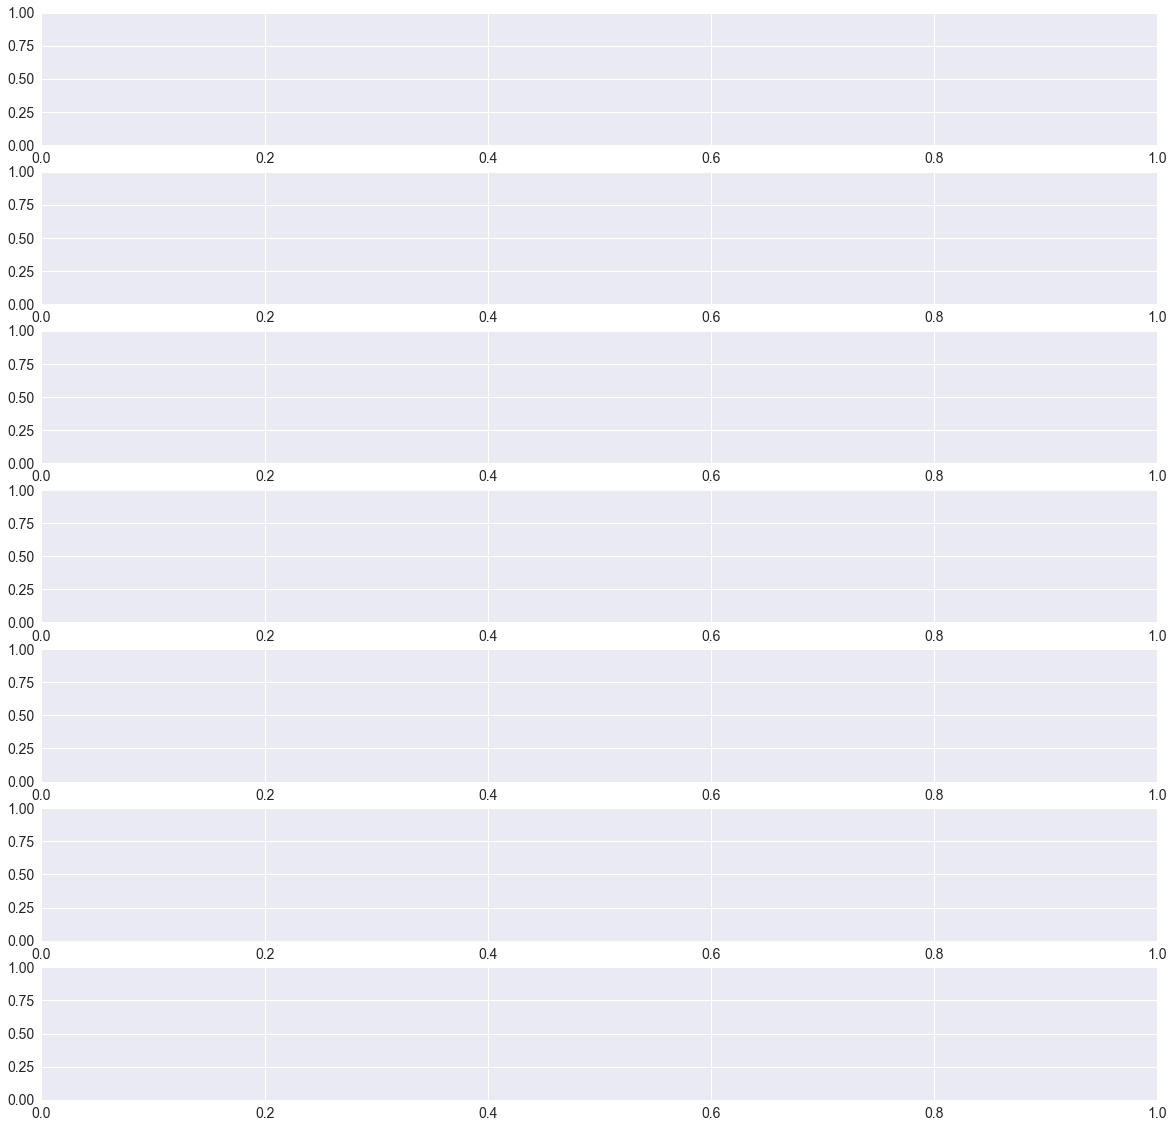

In [190]:
f, axarr = plt.subplots(7, figsize=(20,20))
for i in range(7):
#     print(i,len(input_pbs_train[input_pbs_train['class']==i]))
    if len(input_pbs_train[input_pbs_train['class']==i]) > 1:
        sns.distplot(input_pbs_train[input_pbs_train['class']==i]['view'],ax=axarr[i],bins=50)

In [120]:
# train_data = [numerical_feature_data,title_tokenized_features_data,ner_features]
train_data = [categorical_feature_data,numerical_feature_data,title_tokenized_features_data,ner_features]
train_x = []
temp_train_x = []
test_x = []
val_x = []
for data in train_data:
    train, test = train_test_split(data, test_size=0.1,random_state=22)
    temp_train_x += [train]
    test_x += [test]
for data in temp_train_x:
    train, val = train_test_split(data, test_size=0.1,random_state=22)
    train_x += [train]
    val_x += [val]
temp_train_y, test_y = train_test_split(y_train, test_size=0.1,random_state=22)
train_y, val_y = train_test_split(temp_train_y, test_size=0.1,random_state=22)


In [68]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(train_x2, train_y)

/Users/eqsk134/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [77]:
y_pred = clf.predict(test_x2)

In [78]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_y, y_pred))
rms

0.2967288463341815

In [79]:
mae = np.sum(np.absolute((test_y.astype("float") - y_pred.astype("float"))))/len(y_pred)
mae

1.4406891981444665

In [80]:
score, heatmap = evaluate(y_pred,test_y)
print(score)
# print(heatmap)

[[536 218  64  22  71   8   0   0   0]
 [297 382 150  63 127   7   0   0   0]
 [154 220 121  83 141   7   0   0   0]
 [ 94 152  87  64 129   7   0   0   0]
 [159 228 130 100 274  16   0   0   0]
 [ 53  77  26  19  48  67  34   1   0]
 [  0   0   0   0   0  38  40   1   0]
 [  0   0   0   0   0   4   8   0   0]
 [  0   0   0   0   0   0   0   0   0]]
[1293, 1277, 578, 351, 790, 154, 82, 2, 0]
0.32781091230395404


/Users/eqsk134/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


In [123]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(train_x[1], train_y)
y_pred = clf.predict(test_x[1])
score, heatmap = evaluate(y_pred,test_y)
print(score)

[[519 240  69  32  55   4   0   0   0]
 [274 374 155  74 135  14   0   0   0]
 [144 205 141  69 156  11   0   0   0]
 [ 85 161  98  57 120  12   0   0   0]
 [165 208 138  96 279  21   0   0   0]
 [ 62  62  23  22  51  70  35   0   0]
 [  0   0   0   0   0  36  43   0   0]
 [  0   0   0   0   0   5   7   0   0]
 [  0   0   0   0   0   0   0   0   0]]
[1249, 1250, 624, 350, 796, 173, 85, 0, 0]
0.3275900154627789


/Users/eqsk134/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


In [126]:
train_x[0].shape

(36667, 11)

In [127]:
train_x[1].shape

(36667, 46)

In [128]:
train_x[2].shape

(36667, 26)

In [129]:
train_x[3].shape

(36667, 52)

In [298]:
categorical_feature_data.shape

(45269, 11)

In [42]:
idx1 = 0
for i in train_x[0]:
    idx2 = 0
    for j in i:
        if j != 0.0 and j != 1.0:
            if j != j:
                train_x[0][idx1][idx2] = 0
        idx2 += 1
    idx1 += 1

In [43]:
idx1 = 0
for i in test_x[0]:
    idx2 = 0
    for j in i:
        if j != 0.0 and j != 1.0:
            if j != j:
                test_x[0][idx1][idx2] = 0
        idx2 += 1
    idx1 += 1

In [44]:
idx1 = 0
for i in val_x[0]:
    idx2 = 0
    for j in i:
        if j != 0.0 and j != 1.0:
            if j != j:
                val_x[0][idx1][idx2] = 0
        idx2 += 1
    idx1 += 1

In [65]:
train_x2 = np.concatenate((train_x[0],train_x[1],train_x[2],train_x[3]),axis = 1)

In [66]:
train_x2.shape

(36667, 135)

In [67]:
test_x2 = np.concatenate((test_x[0],test_x[1],test_x[2],test_x[3]),axis = 1)